### Functions to calaculate SFC

In [1]:
import zCurve as z

def calculateMortonFromTwoLatLonFloats_with_zCurve(x, y):
    # Cap floating point numbers to six decimal places
    x_int = int( round( (x + 90.0), 6 ) * 100000 )
    y_int = int( round( (y + 180.0), 6 ) * 100000 )
    value = z.interlace(x_int, y_int, dims=2)
    return value

In [2]:
import numpy as np

def mortonEncode2D(a, b):
    x = np.uint64(a)
    y = np.uint64(b)

    x = (x | (x << np.uint64(16))) & np.uint64(0x0000FFFF0000FFFF)
    x = (x | (x << np.uint64(8)))  & np.uint64(0x00FF00FF00FF00FF)
    x = (x | (x << np.uint64(4)))  & np.uint64(0x0F0F0F0F0F0F0F0F)
    x = (x | (x << np.uint64(2)))  & np.uint64(0x3333333333333333)
    x = (x | (x << np.uint64(1)))  & np.uint64(0x5555555555555555)

    y = (y | (y << np.uint64(16))) & np.uint64(0x0000FFFF0000FFFF)
    y = (y | (y << np.uint64(8)))  & np.uint64(0x00FF00FF00FF00FF)
    y = (y | (y << np.uint64(4)))  & np.uint64(0x0F0F0F0F0F0F0F0F)
    y = (y | (y << np.uint64(2)))  & np.uint64(0x3333333333333333)
    y = (y | (y << np.uint64(1)))  & np.uint64(0x5555555555555555)

    result = np.uint64( x | (y << np.uint64(1)) )
    return result

def mortonExtractEvenBits(a):
    x = np.uint64(a)
    
    x = x & np.uint64(0x5555555555555555)
    x = (x | (x >> np.uint64(1)))  & np.uint64(0x3333333333333333)
    x = (x | (x >> np.uint64(2)))  & np.uint64(0x0F0F0F0F0F0F0F0F)
    x = (x | (x >> np.uint64(4)))  & np.uint64(0x00FF00FF00FF00FF)
    x = (x | (x >> np.uint64(8)))  & np.uint64(0x0000FFFF0000FFFF)
    x = (x | (x >> np.uint64(16))) & np.uint64(0x00000000FFFFFFFF)
    
    return x.astype(np.uint32)

def mortonDecode2D(a):
    _a = np.uint64(a)
    
    x = mortonExtractEvenBits(_a)
    y = mortonExtractEvenBits(_a >> np.uint64(1))
    
    return (x, y)

def calculateMortonFromTwoLatLonFloats(x, y):
    _x = np.float32(x)
    _y = np.float32(y)
    # Cap floating point numbers to six decimal places.
    x_int = np.uint32( np.round( (_x + np.float32(90.0) ), 6 ) * np.uint32(100000) )
    y_int = np.uint32( np.round( (_y + np.float32(180.0) ), 6 ) * np.uint32(100000) )
    value = mortonEncode2D(x_int, y_int)
    return value

def calculateTwoLatLonFloatsFromMorton(a):
    pair = mortonDecode2D(a)
    _x = np.float32(pair[0] / np.float32(100000.0) - np.float32(90.0))
    _y = np.float32(pair[1] / np.float32(100000.0) - np.float32(180.0))
    return (_x, _y)


def calculateMortonFromXYAccelerationFloats(x, y):
    _x = np.float32(x)
    _y = np.float32(y)
    # Cap floating point numbers to six decimal places.
    x_int = np.uint32( np.round( (_x + np.float32(10.0) ), 6 ) * np.uint32(100) )
    y_int = np.uint32( np.round( (_y + np.float32(10.0) ), 6 ) * np.uint32(100) )
    value = mortonEncode2D(x_int, y_int)
    return value

def calculateXYAccelerationFloatsFromMorton(a):
    pair = mortonDecode2D(a)
    _x = np.float32(pair[0] / np.float32(100.0) - np.float32(10.0))
    _y = np.float32(pair[1] / np.float32(100.0) - np.float32(10.0))
    return (_x, _y)

### Lane Change

#### Multiple Lane Change

Graph of the multidimensional data of multiple lane change

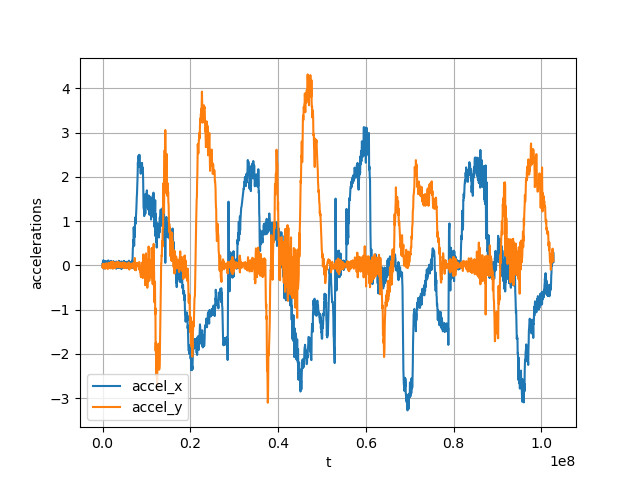

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# First, we read the CSV file.
df_lane_change = pd.read_csv('multiple_lane_changes.csv', sep=';')

%matplotlib ipympl
from mplcursors import cursor
import matplotlib.patches as patches

# Plot the accelerations but this time using the correct resolution of time and subtract by the first value to let the X values start at 0.
offset = df_lane_change['sampleTimeStamp.seconds'][0] * 1000000 + df_lane_change['sampleTimeStamp.microseconds'][0]
df_lane_change['timestamp'] = df_lane_change['sampleTimeStamp.seconds'] * 1000000 + df_lane_change['sampleTimeStamp.microseconds'] - offset

plt.figure()
# plt.figure(figsize=(11, 5))
plt.xlabel('t')
plt.ylabel('accelerations')
plt.plot(df_lane_change['timestamp'], df_lane_change['accel_x'], label="accel_x")
plt.plot(df_lane_change['timestamp'], df_lane_change['accel_y'], label="accel_y")
# plt.plot(df_lane_change['timestamp'], df_lane_change['accel_z'], label="accel_z")
plt.legend(loc="lower left")
plt.grid(True)
cursor(hover=True)

plt.show()

Now we plot the graph into 4 seperate sections so we can see better

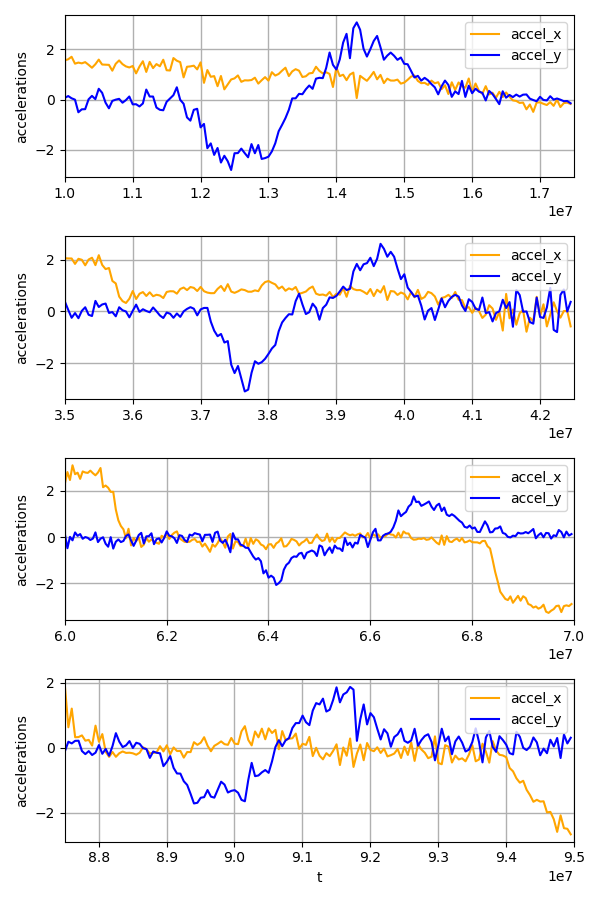

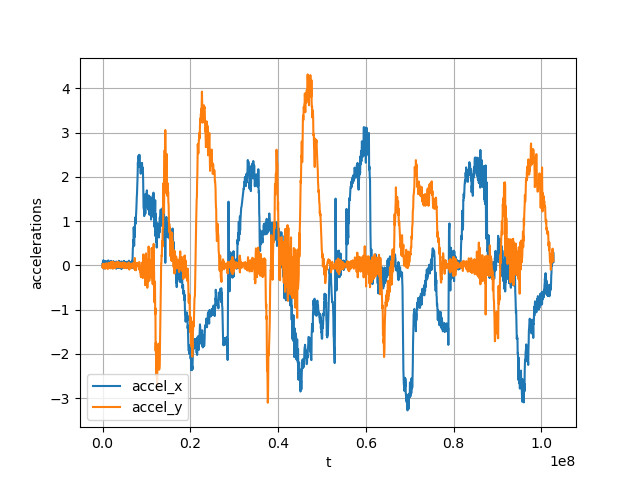

In [8]:
%matplotlib ipympl
from mplcursors import cursor
import matplotlib.patches as patches
from scipy.signal import find_peaks
import numpy as np

# Plot the accelerations but this time using the correct resolution of time and subtract by the first value to let the X values start at 0.
offset = df_lane_change['sampleTimeStamp.seconds'][0] * 1000000 + df_lane_change['sampleTimeStamp.microseconds'][0]
df_lane_change['timestamp'] = df_lane_change['sampleTimeStamp.seconds'] * 1000000 + df_lane_change['sampleTimeStamp.microseconds'] - offset

plt.figure()
plt.xlabel('t')
plt.ylabel('accelerations')
plt.plot(df_lane_change['timestamp'], df_lane_change['accel_x'], label="accel_x")
plt.plot(df_lane_change['timestamp'], df_lane_change['accel_y'], label="accel_y")
#plt.plot(df_lane_change['timestamp'], df_lane_change['accel_z'], label="accel_z")
plt.legend(loc="lower left")
plt.grid(True)
cursor(hover=True)

segments = [
    (0.10 * 1e8, 0.175 * 1e8),  # Segment 1
    (0.35 * 1e8, 0.425 * 1e8),  # Segment 2
    (0.6 * 1e8, 0.7 * 1e8),  # Segment 3
    (0.875 * 1e8, 0.95 * 1e8)   # Segment 4
]

# Create a figure with four subplots (one for each segment)
fig, axs = plt.subplots(len(segments), 1, figsize=(6, 9))  # Adjust figsize to your preference

# Loop through the segments and plot each on a separate subplot
for i, (start, end) in enumerate(segments):
    # Filter the data for the current segment
    segment_data = df_lane_change[(df_lane_change['timestamp'] >= start) & (df_lane_change['timestamp'] <= end)]
    
    # Plot the segment data on the ith subplot
    axs[i].plot(segment_data['timestamp'], segment_data['accel_x'], label='accel_x', color='orange')
    axs[i].plot(segment_data['timestamp'], segment_data['accel_y'], label='accel_y', color='blue')
    # If you have accel_z data, you can uncomment the next line
    # axs[i].plot(segment_data['timestamp'], segment_data['accel_z'], label='accel_z', color='green')
    
    # Set the x-axis limits to the segment we are plotting
    axs[i].set_xlim(start, end)
    
    # Add the grid, legend, and other plot features
    axs[i].grid(True)
    axs[i].grid(which = "major", linewidth = 1)
    axs[i].grid(which = "minor", linewidth = 0.2)
    axs[i].legend(loc='upper right')
     # cursor(axs[i], hover=True)

    # Set common labels
    axs[i].set_ylabel('accelerations')

# Set xlabel for the last subplot only
axs[-1].set_xlabel('t')

plt.tight_layout()
plt.show()

#####  Feeding y accel value in the SFC

In [9]:
threshold_1 = -1.6
threshold_2 = 2
times_for_maneuver_lc = []
for _, row in df_lane_change.iterrows():
    # The following line has been commented out for readability purposes.
    #print( str(row['timestamp']) + ": "+ str(row['accel_x']) )
    if  row['accel_y'] < threshold_1 or row['accel_y'] > threshold_2 :
        print( "Maneuver at " + str(row['timestamp']) )
        times_for_maneuver_lc.append(row['timestamp'])
print( "Length of maneuver: " + str(len(times_for_maneuver_lc)) )

Maneuver at 12100318.0
Maneuver at 12150398.0
Maneuver at 12200466.0
Maneuver at 12250385.0
Maneuver at 12300336.0
Maneuver at 12350358.0
Maneuver at 12400324.0
Maneuver at 12450639.0
Maneuver at 12500350.0
Maneuver at 12550356.0
Maneuver at 12600346.0
Maneuver at 12650369.0
Maneuver at 12700351.0
Maneuver at 12750405.0
Maneuver at 12800415.0
Maneuver at 12850370.0
Maneuver at 12900343.0
Maneuver at 12950354.0
Maneuver at 13000422.0
Maneuver at 13050392.0
Maneuver at 13100395.0
Maneuver at 14100381.0
Maneuver at 14150459.0
Maneuver at 14250421.0
Maneuver at 14300478.0
Maneuver at 14350398.0
Maneuver at 14400428.0
Maneuver at 14550458.0
Maneuver at 14600470.0
Maneuver at 14650440.0
Maneuver at 20150667.0
Maneuver at 20300609.0
Maneuver at 20350631.0
Maneuver at 20400613.0
Maneuver at 20450912.0
Maneuver at 20500611.0
Maneuver at 20550643.0
Maneuver at 21600726.0
Maneuver at 21650661.0
Maneuver at 21700652.0
Maneuver at 21750678.0
Maneuver at 21800703.0
Maneuver at 21850675.0
Maneuver at

In [10]:
counter = 0
for _, row in df_lane_change.iterrows():
    morton = calculateMortonFromXYAccelerationFloats(row['accel_x'], row['accel_y'])
    print( str(row['timestamp']) + ": (" + str(row['accel_x']) + ",0) --> " + str(morton) )
    counter = counter + 1
print( "Processed " + str(counter) + " rows." )

0.0: (0.0340612,0) --> 1047653
49944.0: (-0.0543692,0) --> 1047692
99933.0: (0.101629,0) --> 1047814
149979.0: (-0.0483371,0) --> 1047693
200049.0: (0.116677,0) --> 1047823
249970.0: (-0.0476056,0) --> 1047693
300032.0: (0.0916287,0) --> 1047843
349956.0: (-0.0733521,0) --> 1047690
399963.0: (0.0420668,0) --> 1047768
450161.0: (-0.0461468,0) --> 1047687
499955.0: (0.013979,0) --> 1047753
549970.0: (0.010659,0) --> 1047657
600001.0: (0.00442924,0) --> 1047744
650006.0: (0.0664857,0) --> 1047636
699972.0: (-0.0395075,0) --> 1047698
750054.0: (0.10129,0) --> 1047814
800093.0: (-0.0572625,0) --> 1047716
849999.0: (0.080413,0) --> 1047850
899983.0: (-0.0581026,0) --> 1047694
949994.0: (0.0691199,0) --> 1047766
1000050.0: (-0.0381634,0) --> 1047698
1049986.0: (0.0159526,0) --> 1047747
1099959.0: (0.0248644,0) --> 1047630
1150000.0: (0.00933258,0) --> 1047744
1200059.0: (0.0733542,0) --> 1046271
1249993.0: (-0.0425052,0) --> 1047693
1299990.0: (0.113727,0) --> 1047823
1350013.0: (-0.0466957,0

In [11]:
lst = []
longitudinal_accel = 0
for _, row in df_lane_change.iterrows():
    morton = calculateMortonFromXYAccelerationFloats(longitudinal_accel, row['accel_y'])
    lst.append({'morton': morton, 'timestamp': row['timestamp']})

df_6 = pd.DataFrame(lst, columns=['morton', 'timestamp'])
print( df_6 )

       morton    timestamp
0     1047648          0.0
1     1047752      49944.0
2     1047618      99933.0
3     1047752     149979.0
4     1047626     200049.0
...       ...          ...
2051  2446562  102553351.0
2052  1048298  102603339.0
2053  2446408  102653360.0
2054  1048288  102703358.0
2055  1048130  102753397.0

[2056 rows x 2 columns]


We plotted all the 4 lane changes in the single-dimensional representation before dividing them up into 4 Segments, see below for more information.

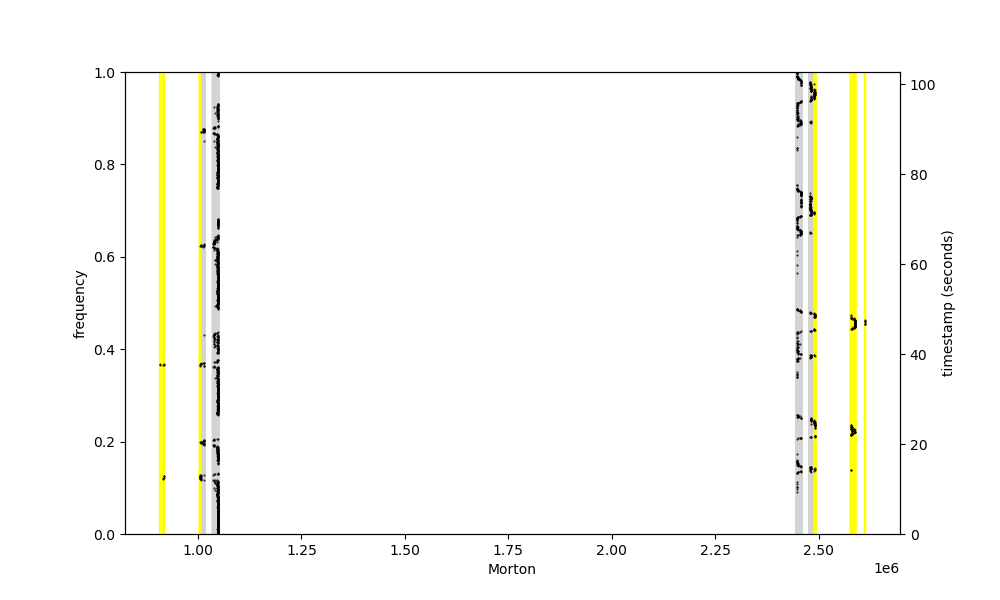

In [12]:
import numpy as np
import matplotlib.pyplot as plt

group_A = []
group_B = []
for _, row in df_6.iterrows():
    morton = row['morton']
    timestamp = row['timestamp']
    if timestamp in times_for_maneuver_lc:
        group_A.append(morton)
    else:
        group_B.append(morton)

data1 = [group_A, group_B]
data_colors = ['yellow', 'lightgray']


data = df_6['morton']  # Morton order data
timestamp_micro = df_6['timestamp']  # Timestamp data

# Convert timestamp from scientific notation to decimal notation
# We are dividing with large number to get into a reasonable range for plotting
timestamp_seconds = timestamp_micro / 1e6

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.xlabel('Morton')
plt.ylabel('frequency')
plt.ylim((0, 1))

# Plot the occurrences as vertical lines instead of horizontal
# plt.vlines(data, 0, 1, colors='lightgrey', linestyles='solid',linewidth = 4)
plt.eventplot(data1, orientation='horizontal', colors=data_colors, lineoffsets=[0.5, 0.5])
# Create a second y-axis for the timestamps
ax2 = plt.twinx()
ax2.set_ylabel('timestamp (seconds)')
# Set the limit for the timestamp y-axis to align with the data
ax2.set_ylim([min(timestamp_seconds), max(timestamp_seconds)])

# Plot the timestamps on this new y-axis, aligned with the occurrences on the left y-axis
ax2.scatter(data, timestamp_seconds, color='black', s=0.2)  # Adjust size of dots


plt.show()

We then divide the 4 lane change into 4 segment by analysing the graph
Here we have the first segemt

In [13]:
seg1 = []
lst1 = []

counter = 0
longitudinal_acceleration = 0.0
for _, row in df_lane_change.iterrows():
    if row['timestamp'] < 1.75e7 and row['timestamp']> 1e7:  # Here we divide the first segment according to the timestamp
        morton = calculateMortonFromXYAccelerationFloats(longitudinal_acceleration, row['accel_y'])
        timestamp =  row['timestamp'] - 1e7
        seg1.append({'morton': morton, 'timestamp': timestamp})
        lst1.append({'accel_y': row['accel_y'],'morton': morton})
        counter = counter + 1

df_seg1 = pd.DataFrame(seg1, columns=['morton', 'timestamp'])
print( df_seg1 )

print( "Processed " + str(counter) + " rows." )

      morton  timestamp
0    1047784      311.0
1    1048162    50284.0
2    1047776   100265.0
3    1047658   150303.0
4    1039970   200310.0
..       ...        ...
145  1047776  7250544.0
146  1047658  7300541.0
147  1047618  7350524.0
148  1047624  7400543.0
149  1046210  7450780.0

[150 rows x 2 columns]
Processed 150 rows.


Second segment, here we are adjusting the timestamp so that all the plots can allign into one graph i.e making it start from 0

In [14]:
seg2 = []

counter = 0
longitudinal_acceleration = 0.0
for _, row in df_lane_change.iterrows():
    if row['timestamp'] < 4.25e7 and row['timestamp']> 3.5e7:
        morton = calculateMortonFromXYAccelerationFloats(longitudinal_acceleration, row['accel_y'])
        timestamp =  row['timestamp'] - 3.5e7
        seg2.append({'morton': morton, 'timestamp': timestamp})
        lst1.append({'accel_y': row['accel_y'],'morton': morton})
        counter = counter + 1

df_seg2 = pd.DataFrame(seg2, columns=['morton', 'timestamp'])
print( df_seg2 )

print( "Processed " + str(counter) + " rows." )


      morton  timestamp
0    2446562     1163.0
1    1047778    51137.0
2    1045738   101111.0
3    1047618   151158.0
4    1045730   201146.0
..       ...        ...
145  1037930  7251389.0
146  2448490  7301344.0
147  2449120  7351366.0
148  1047658  7401342.0
149  2446560  7451603.0

[150 rows x 2 columns]
Processed 150 rows.


Third Segement

In [15]:
seg3 = []

counter = 0
longitudinal_acceleration = 0.0
for _, row in df_lane_change.iterrows():
    if row['timestamp'] < 7e7 and row['timestamp']> 6.25e7:
        morton = calculateMortonFromXYAccelerationFloats(longitudinal_acceleration, row['accel_y'])
        timestamp =  row['timestamp'] - 6.25e7
        seg3.append({'morton': morton, 'timestamp': timestamp})
        lst1.append({'accel_y': row['accel_y'],'morton': morton})
        counter = counter + 1

df_seg3 = pd.DataFrame(seg3, columns=['morton', 'timestamp'])
print( df_seg3 )

print( "Processed " + str(counter) + " rows." )


      morton  timestamp
0    1047784     2065.0
1    1048258    51990.0
2    1048162   102009.0
3    1048138   152029.0
4    1046120   202093.0
..       ...        ...
145  1048296  7252254.0
146  1047658  7302321.0
147  2446400  7352282.0
148  1047786  7402256.0
149  1048162  7452264.0

[150 rows x 2 columns]
Processed 150 rows.


Fourth Segment

In [16]:
seg4 = []

counter = 0
longitudinal_acceleration = 0.0
for _, row in df_lane_change.iterrows():
    if row['timestamp'] < 9.5e7 and row['timestamp']> 8.75e7:
        morton = calculateMortonFromXYAccelerationFloats(longitudinal_acceleration, row['accel_y'])
        timestamp =  row['timestamp'] - 8.75e7
        seg4.append({'morton': morton, 'timestamp': timestamp})
        lst1.append({'accel_y': row['accel_y'],'morton': morton})
        counter = counter + 1

df_seg4 = pd.DataFrame(seg4, columns=['morton', 'timestamp'])
print( df_seg4 )

print( "Processed " + str(counter) + " rows." )

      morton  timestamp
0    1046248     2984.0
1    1048264    52862.0
2    1048162   102867.0
3    1048290   152872.0
4    1048290   202891.0
..       ...        ...
145  2446440  7253111.0
146  1045696  7303135.0
147  2446914  7353084.0
148  1048162  7403097.0
149  2446442  7453105.0

[150 rows x 2 columns]
Processed 150 rows.


 We seperate the morton value in terms of acceleration by getting the min and max values of acceleration that it need to surpase to count it as a lane change

In [17]:
max_lowerBox = -1.5
min_upperBox = 1.5
group_A1 = []
group_B1 = []

for z in lst1:
    if  z['accel_y'] < max_lowerBox or z['accel_y'] > min_upperBox:
        morton = z['morton']
        group_A1.append(morton)
    else:
        morton = z['morton']
        group_B1.append(morton)

Here we stack all the 4 segments and highlight the area of interest 

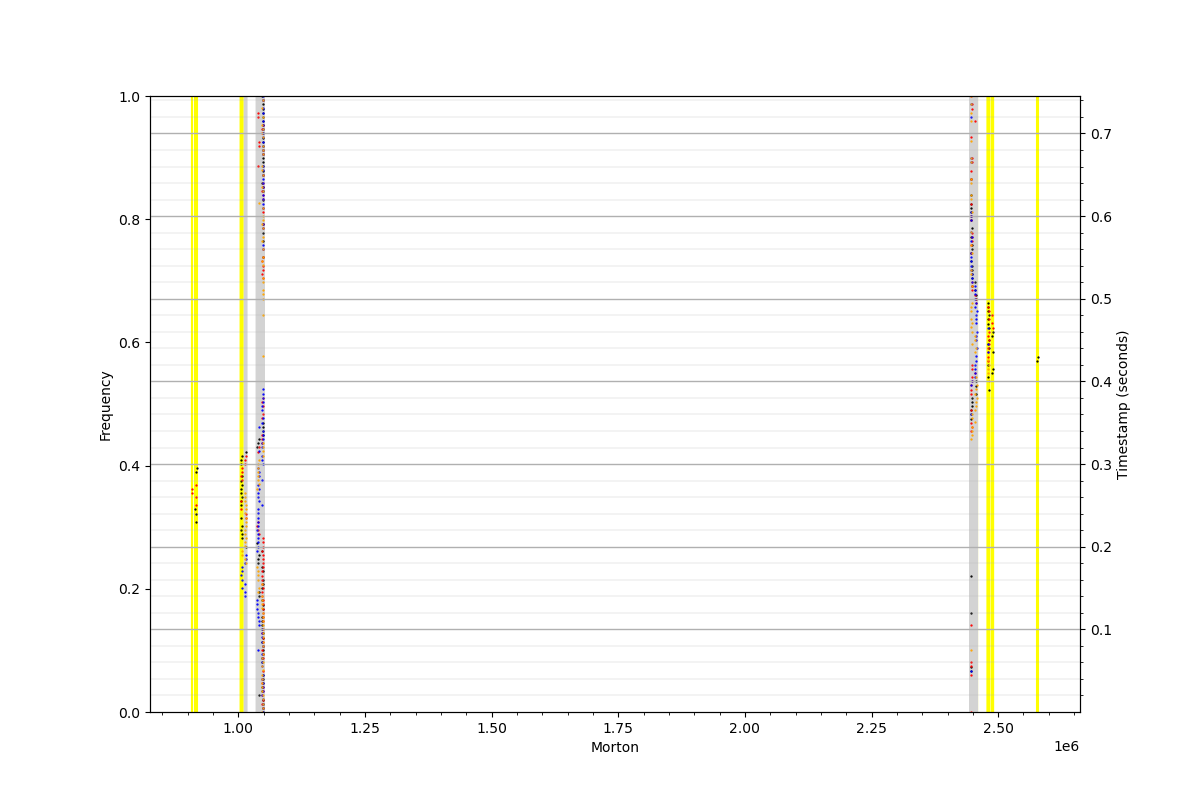

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Highlighting the data we are interested in
data1 = [group_A1, group_B1]
data_colors = ['yellow', 'lightgray']

# Assuming df_seg1, df_seg2, df_seg3, df_seg4, df_lane_change_morton are predefined DataFrames
# Assuming times_for_maneuver_lc is predefined

# Extract data from segments
data_segments = [df_seg1, df_seg2, df_seg3, df_seg4]
data = []
timestamp_seconds = []
for df in data_segments:
    data.append(df['morton'])
    timestamp_micro = df['timestamp']
    timestamp_sec = timestamp_micro / 1e7
    timestamp_seconds.append(timestamp_sec)

# Calculate global timestamp limits
min_timestamp = min(min(ts) for ts in timestamp_seconds)
max_timestamp = max(max(ts) for ts in timestamp_seconds)

# Plotting
plt.figure(figsize=(12, 8))

plt.eventplot(data1, orientation='horizontal', colors=data_colors, lineoffsets=[0.5, 0.5])

plt.xlabel('Morton')
plt.ylabel('Frequency')
plt.ylim((0, 1))
# plt.xlim(2.48e6,2.5e6)

# Create a second y-axis for timestamps
ax2 = plt.twinx()
ax2.set_ylabel('Timestamp (seconds)')
ax2.set_ylim([min_timestamp, max_timestamp])
ax2.grid(which = "major", linewidth = 1)
ax2.grid(which = "minor", linewidth = 0.2)
ax2.minorticks_on()

# Plot timestamps as scatter points
colors = ['black', 'red', 'blue', 'orange']
for ds, color, ts in zip(data, colors, timestamp_seconds):
    ax2.scatter(ds, ts, color=color, s=0.4)


plt.show()


Drew boxes in the area of interest

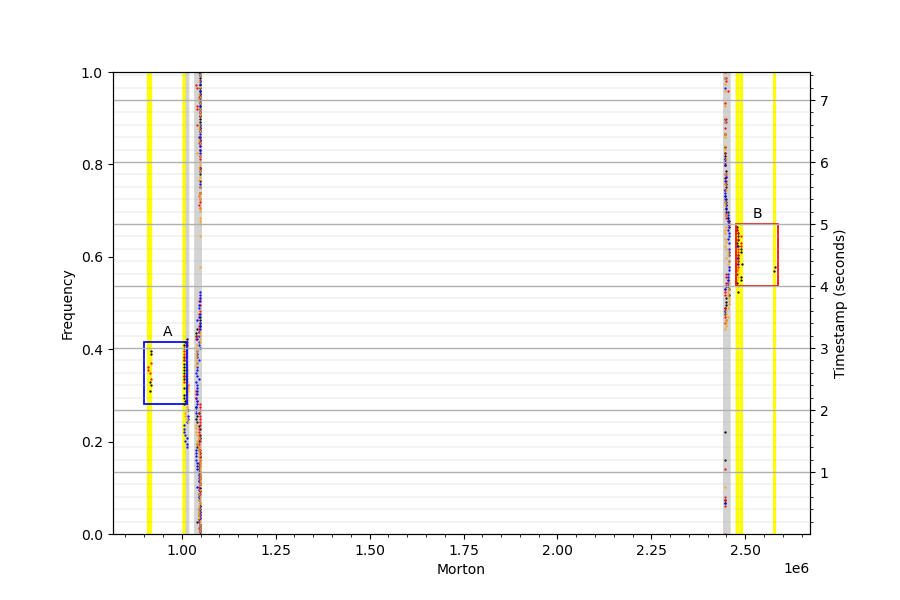

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Highlighting the data we are interested in
data1 = [group_A1, group_B1]
data_colors = ['yellow', 'lightgray']

# Assuming df_seg1, df_seg2, df_seg3, df_seg4, df_lane_change_morton are predefined DataFrames
# Assuming times_for_maneuver_lc is predefined

# Extract data from segments
data_segments = [df_seg1, df_seg2, df_seg3, df_seg4]
data = []
timestamp_seconds = []
for df in data_segments:
    data.append(df['morton'])
    timestamp_micro = df['timestamp']
    timestamp_sec = timestamp_micro / 1e6
    timestamp_seconds.append(timestamp_sec)

# Calculate global timestamp limits
min_timestamp = min(min(ts) for ts in timestamp_seconds)
max_timestamp = max(max(ts) for ts in timestamp_seconds)

# Plotting
plt.figure(figsize=(9, 6))

plt.eventplot(data1, orientation='horizontal', colors=data_colors, lineoffsets=[0.5, 0.5])

plt.xlabel('Morton')
plt.ylabel('Frequency')
plt.ylim((0, 1))

# Create a second y-axis for timestamps
ax2 = plt.twinx()
ax2.set_ylabel('Timestamp (seconds)')
ax2.set_ylim([min_timestamp, max_timestamp])
ax2.grid(which = "major", linewidth = 1)
ax2.grid(which = "minor", linewidth = 0.2)
ax2.minorticks_on()

# Plot timestamps as scatter points
colors = ['black', 'red', 'blue', 'orange']
for ds, color, ts in zip(data, colors, timestamp_seconds):
    ax2.scatter(ds, ts, color=color, s=0.4)

# Draw boxes 
plt.text(0.95*1e6, 3.2, 'A')
lower = patches.Rectangle( (0.9*1e6, 2.1), 1.13e5, 1, linewidth=1.25, edgecolor="blue", facecolor='none')
plt.text(2.52*1e6, 5.1, 'B')
upper = patches.Rectangle( (2.475*1e6, 4), 1.13e5, 1, linewidth=1.25, edgecolor="red", facecolor='none')

plt.gca().add_patch(lower)
plt.gca().add_patch(upper)

plt.show()

#####  Feeding both y and x accel in the SFC

In [20]:
lst = []
seg1x = []

counter = 0

for _, row in df_lane_change.iterrows():
    if row['timestamp'] < 1.75e7 and row['timestamp']> 1e7:  # Here we divide the first segment according to the timestamp
        morton = calculateMortonFromXYAccelerationFloats(row['accel_x'], row['accel_y'])
        seg1x.append({'morton': morton, 'timestamp': row['timestamp']})
        lst.append({'accel_y': row['accel_y'],'morton': morton})
        counter = counter + 1

df_seg1x = pd.DataFrame(seg1x, columns=['morton', 'timestamp'])

seg2x = []
counter = 0

for _, row in df_lane_change.iterrows():
    if row['timestamp'] < 4.25e7 and row['timestamp']> 3.5e7:
        morton = calculateMortonFromXYAccelerationFloats(row['accel_x'], row['accel_y'])
        timestamp =  row['timestamp'] - 2.5e7
        seg2x.append({'morton': morton, 'timestamp': timestamp})
        lst.append({'accel_y': row['accel_y'],'morton': morton})
        counter = counter + 1

df_seg2x = pd.DataFrame(seg2x, columns=['morton', 'timestamp'])


seg3x = []
counter = 0

longitudinal_acceleration = 0.0
for _, row in df_lane_change.iterrows():
    if row['timestamp'] < 7e7 and row['timestamp']> 6.25e7:
        morton = calculateMortonFromXYAccelerationFloats(row['accel_x'], row['accel_y'])
        timestamp =  row['timestamp'] - 5.25e7
        seg3x.append({'morton': morton, 'timestamp': timestamp})
        lst.append({'accel_y': row['accel_y'],'morton': morton})
        counter = counter + 1

df_seg3x = pd.DataFrame(seg3x, columns=['morton', 'timestamp'])


seg4x = []
counter = 0

for _, row in df_lane_change.iterrows():
    if row['timestamp'] < 9.5e7 and row['timestamp']> 8.75e7:
        morton = calculateMortonFromXYAccelerationFloats(row['accel_x'], row['accel_y'])
        timestamp =  row['timestamp'] - 7.75e7
        seg4x.append({'morton': morton, 'timestamp': timestamp})
        lst.append({'accel_y': row['accel_y'],'morton': morton})
        counter = counter + 1

df_seg4x = pd.DataFrame(seg4x, columns=['morton', 'timestamp'])


max_lowerBox = -2
min_upperBox = 2
data_segments = [df_seg1x, df_seg2x, df_seg3x, df_seg4x]
group_A = []
group_B = []

for y in lst:
    if  y['accel_y'] < max_lowerBox or y['accel_y'] > min_upperBox:
        morton = y['morton']
        group_A.append(morton)
    else:
        morton = y['morton']
        group_B.append(morton)

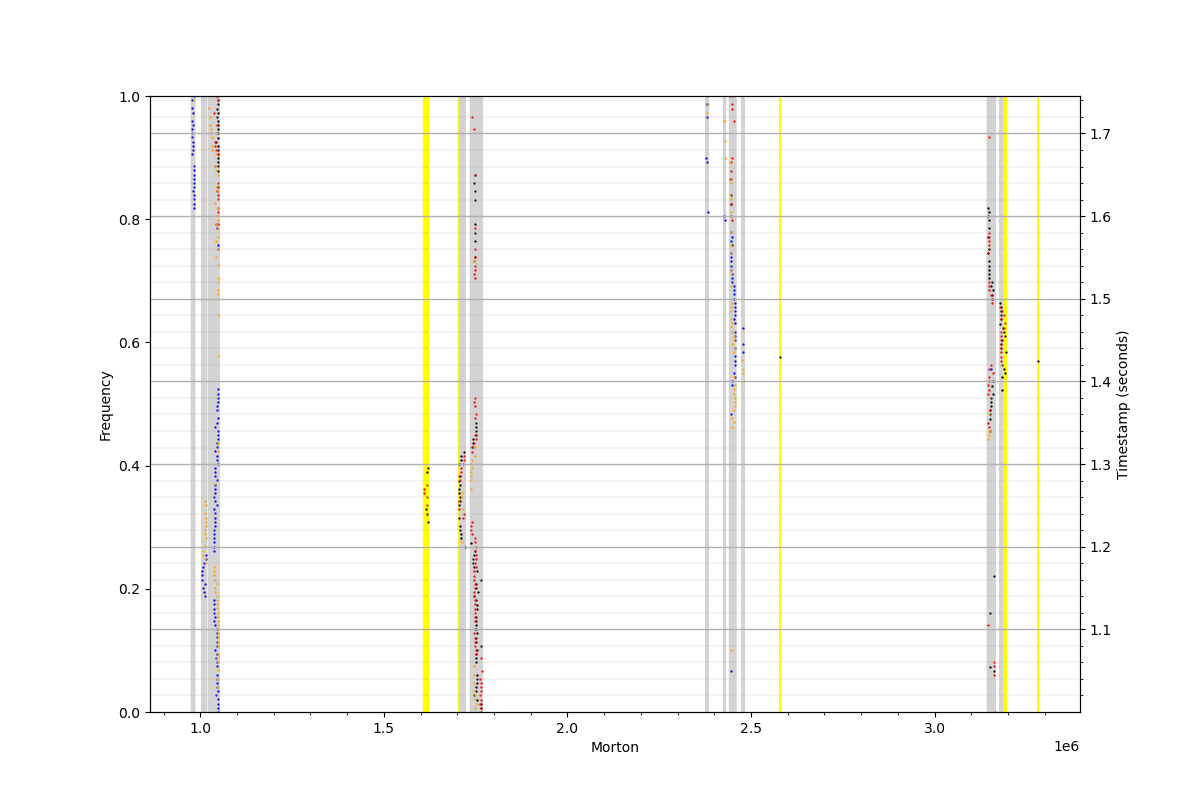

In [21]:
import numpy as np
import matplotlib.pyplot as plt

data1 = [group_A, group_B]
data_colors = ['yellow', 'lightgray']

# Assuming df_seg1, df_seg2, df_seg3, df_seg4, df_lane_change_morton are predefined DataFrames
# Assuming times_for_maneuver_lc is predefined

# Extract data from segments
data_segments = [df_seg1x, df_seg2x, df_seg3x, df_seg4x]
data = []
timestamp_seconds = []
for df in data_segments:
    data.append(df['morton'])
    timestamp_micro = df['timestamp']
    timestamp_sec = timestamp_micro / 1e7
    timestamp_seconds.append(timestamp_sec)

# Calculate global timestamp limits
min_timestamp = min(min(ts) for ts in timestamp_seconds)
max_timestamp = max(max(ts) for ts in timestamp_seconds)

# Plotting
plt.figure(figsize=(12, 8))

plt.eventplot(data1, orientation='horizontal', colors=data_colors, lineoffsets=[0.5, 0.5])

plt.xlabel('Morton')
plt.ylabel('Frequency')
plt.ylim((0, 1))

# Create a second y-axis for timestamps
ax2 = plt.twinx()
ax2.set_ylabel('Timestamp (seconds)')
ax2.set_ylim([min_timestamp, max_timestamp])
ax2.grid(which = "major", linewidth = 1)
ax2.grid(which = "minor", linewidth = 0.2)
ax2.minorticks_on()

# Plot timestamps as scatter points
colors = ['black', 'red', 'blue', 'orange']
for ds, color, ts in zip(data, colors, timestamp_seconds):
    ax2.scatter(ds, ts, color=color, s=0.4)


plt.show()


#### Single Lane change 

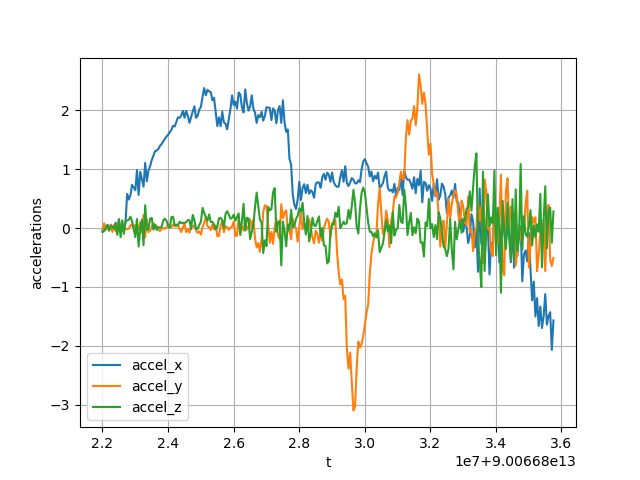

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# First, we read the CSV file.
df_lane_change = pd.read_csv('lane_change.csv', sep=';')

# Plot the accelerations but this time using the correct resolution of time.
df_lane_change['timestamp'] = df_lane_change['sampleTimeStamp.seconds'] * 1000000 + df_lane_change['sampleTimeStamp.microseconds']



plt.figure()
plt.xlabel('t')
plt.ylabel('accelerations')
plt.plot(df_lane_change['timestamp'], df_lane_change['accel_x'], label="accel_x")
plt.plot(df_lane_change['timestamp'], df_lane_change['accel_y'], label="accel_y")
plt.plot(df_lane_change['timestamp'], df_lane_change['accel_z'], label="accel_z")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

In [23]:
threshold_1 = -2.5
threshold_2 = 2.2
times_for_maneuver_lc = []
for _, row in df_lane_change.iterrows():
    # The following line has been commented out for readability purposes.
    #print( str(row['timestamp']) + ": "+ str(row['accel_x']) )
    if  row['accel_y'] < threshold_1 or row['accel_y'] > threshold_2 :
        print( "Maneuver at " + str(row['timestamp']) )
        times_for_maneuver_lc.append(row['timestamp'])
print( "Length of maneuver: " + str(len(times_for_maneuver_lc)) )

Maneuver at 90066829604790.0
Maneuver at 90066829654791.0
Maneuver at 90066829704774.0
Maneuver at 90066831654849.0
Maneuver at 90066831704861.0
Maneuver at 90066831804885.0
Length of maneuver: 6


#####  Feeding only y accel in the SFC

In [24]:
counter = 0
longitudinal_accel = 0

for _, row in df_lane_change.iterrows():
    morton = calculateMortonFromXYAccelerationFloats(longitudinal_accel, row['accel_y'])
    print( str(row['timestamp']) + ": (" + str(row['accel_x']) + ",0) --> " + str(morton) )
    counter = counter + 1
print( "Processed " + str(counter) + " rows." )

90066822004583.0: (-0.0520667,0) --> 1047650
90066822054564.0: (0.0388273,0) --> 1048128
90066822104549.0: (0.00042123,0) --> 1047650
90066822154554.0: (0.0570567,0) --> 1047754
90066822204569.0: (-0.0299872,0) --> 1047626
90066822254540.0: (0.0578943,0) --> 1047778
90066822304529.0: (0.0210833,0) --> 1047618
90066822354564.0: (0.0174745,0) --> 1047776
90066822404547.0: (0.0908629,0) --> 1047624
90066822454842.0: (-0.057315,0) --> 1047786
90066822504576.0: (0.142732,0) --> 1047624
90066822554545.0: (-0.0735975,0) --> 1047754
90066822604540.0: (0.08656,0) --> 1047626
90066822654540.0: (-0.0610962,0) --> 1047746
90066822704539.0: (0.0919961,0) --> 1047658
90066822754565.0: (0.579202,0) --> 1047650
90066822804604.0: (0.48389,0) --> 1047658
90066822854534.0: (0.556501,0) --> 1047776
90066822904556.0: (0.734354,0) --> 1047778
90066822954532.0: (0.689343,0) --> 1047744
90066823004619.0: (0.643961,0) --> 1047778
90066823054581.0: (0.985848,0) --> 1047656
90066823104609.0: (0.562318,0) --> 104

In [25]:
lst = []
longitudinal_accel = 0
for _, row in df_lane_change.iterrows():
    morton = calculateMortonFromXYAccelerationFloats(longitudinal_accel, row['accel_y'])
    lst.append({'morton': morton, 'timestamp': row['timestamp']})

df_3 = pd.DataFrame(lst, columns=['morton', 'timestamp'])
print( df_3 )

      morton     timestamp
0    1047650  9.006682e+13
1    1048128  9.006682e+13
2    1047650  9.006682e+13
3    1047754  9.006682e+13
4    1047626  9.006682e+13
..       ...           ...
271  1048168  9.006684e+13
272  2446570  9.006684e+13
273  1039946  9.006684e+13
274  1039466  9.006684e+13
275  1039970  9.006684e+13

[276 rows x 2 columns]


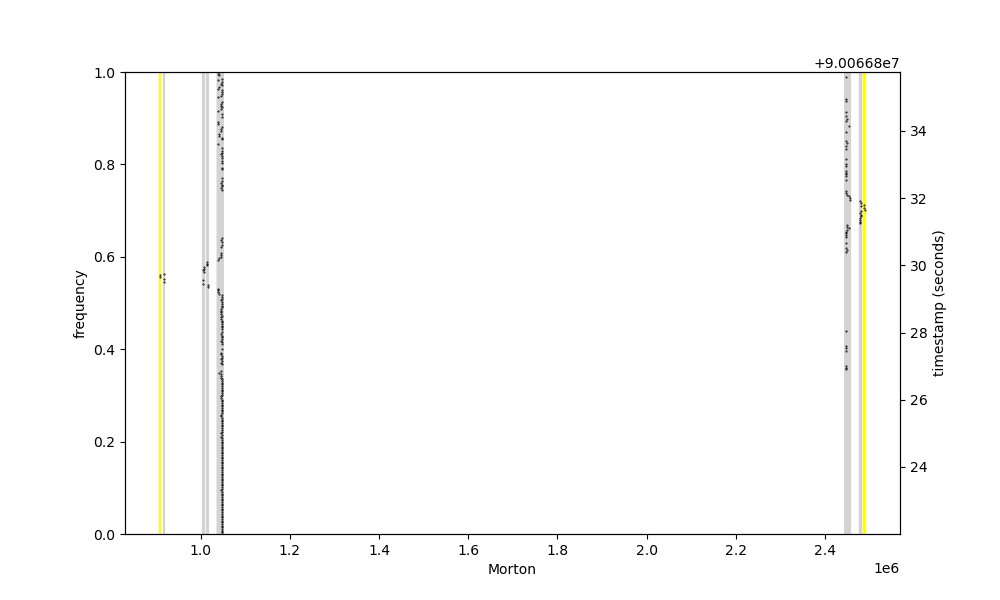

In [26]:
import numpy as np
import matplotlib.pyplot as plt

group_A = []
group_B = []
for _, row in df_3.iterrows():
    morton = row['morton']
    timestamp = row['timestamp']
    if timestamp in times_for_maneuver_lc:
        group_A.append(morton)
    else:
        group_B.append(morton)

data1 = [group_A, group_B]
data_colors = ['yellow', 'lightgray']


data = df_3['morton']  # Morton order data
timestamp_micro = df_3['timestamp']  # Timestamp data

# Convert timestamp from scientific notation to decimal notation
# We are dividing with large number to get into a reasonable range for plotting
timestamp_seconds = timestamp_micro / 1e6

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.xlabel('Morton')
plt.ylabel('frequency')
plt.ylim((0, 1))

# Plot the occurrences as vertical lines instead of horizontal
# plt.vlines(data, 0, 1, colors='lightgrey', linestyles='solid',linewidth = 4)
plt.eventplot(data1, orientation='horizontal', colors=data_colors, lineoffsets=[0.5, 0.5])
# Create a second y-axis for the timestamps
ax2 = plt.twinx()
ax2.set_ylabel('timestamp (seconds)')
# Set the limit for the timestamp y-axis to align with the data
ax2.set_ylim([min(timestamp_seconds), max(timestamp_seconds)])

# Plot the timestamps on this new y-axis, aligned with the occurrences on the left y-axis
ax2.scatter(data, timestamp_seconds, color='black', s=0.2)  # Adjust size of dots


plt.show()

#####  Feeding both x and y accel in the SFC

In [27]:
counter = 0
for _, row in df_lane_change.iterrows():
    morton = calculateMortonFromXYAccelerationFloats(row['accel_x'], row['accel_y'])
    print( str(row['timestamp']) + ": (" + str(row['accel_x']) + ",0) --> " + str(morton) )
    counter = counter + 1
print( "Processed " + str(counter) + " rows." )

90066822004583.0: (-0.0520667,0) --> 1047590
90066822054564.0: (0.0388273,0) --> 1048133
90066822104549.0: (0.00042123,0) --> 1047650
90066822154554.0: (0.0570567,0) --> 1047771
90066822204569.0: (-0.0299872,0) --> 1047579
90066822254540.0: (0.0578943,0) --> 1047795
90066822304529.0: (0.0210833,0) --> 1047622
90066822354564.0: (0.0174745,0) --> 1047777
90066822404547.0: (0.0908629,0) --> 1047817
90066822454842.0: (-0.057315,0) --> 1047726
90066822504576.0: (0.142732,0) --> 1047836
90066822554545.0: (-0.0735975,0) --> 1047690
90066822604540.0: (0.08656,0) --> 1047818
90066822654540.0: (-0.0610962,0) --> 1047683
90066822704539.0: (0.0919961,0) --> 1047851
90066822754565.0: (0.579202,0) --> 1748003
90066822804604.0: (0.48389,0) --> 1747306
90066822854534.0: (0.556501,0) --> 1747445
90066822904556.0: (0.734354,0) --> 1748387
90066822954532.0: (0.689343,0) --> 1748176
90066823004619.0: (0.643961,0) --> 1748194
90066823054581.0: (0.985848,0) --> 1751148
90066823104609.0: (0.562318,0) --> 174

In [28]:
lst = []
for _, row in df_lane_change.iterrows():
    morton = calculateMortonFromXYAccelerationFloats(row['accel_x'], row['accel_y'])
    lst.append({'morton': morton, 'timestamp': row['timestamp']})

df_4 = pd.DataFrame(lst, columns=['morton', 'timestamp'])
print( df_4 )

      morton     timestamp
0    1047590  9.006682e+13
1    1048133  9.006682e+13
2    1047650  9.006682e+13
3    1047771  9.006682e+13
4    1047579  9.006682e+13
..       ...           ...
271  1030712  9.006684e+13
272  2429358  9.006684e+13
273  1022795  9.006684e+13
274  1018218  9.006684e+13
275  1022567  9.006684e+13

[276 rows x 2 columns]


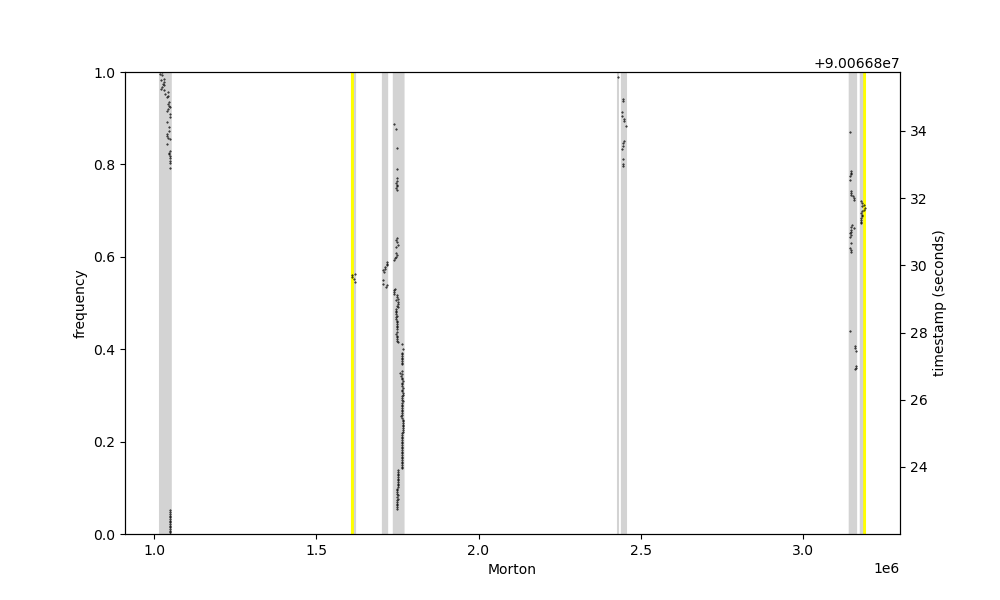

In [29]:
import numpy as np
import matplotlib.pyplot as plt

group_A = []
group_B = []
for _, row in df_4.iterrows():
    morton = row['morton']
    timestamp = row['timestamp']
    if timestamp in times_for_maneuver_lc:
        group_A.append(morton)
    else:
        group_B.append(morton)

data1 = [group_A, group_B]
data_colors = ['yellow', 'lightgray']

data = df_4['morton']  # Morton order data
timestamp_micro = df_4['timestamp']  # Timestamp data

# Convert timestamp from scientific notation to decimal notation
# We are dividing with large number to get into a reasonable range for plotting
timestamp_seconds = timestamp_micro / 1e6

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.xlabel('Morton')
plt.ylabel('frequency')
plt.ylim((0, 1))

# Plot the occurrences as vertical lines instead of horizontal
#plt.vlines(data, 0, 1, colors='lightgrey', linestyles='solid',linewidth = 4)
plt.eventplot(data1, orientation='horizontal', colors=data_colors, lineoffsets=[0.5, 0.5])
# Create a second y-axis for the timestamps
ax2 = plt.twinx()
ax2.set_ylabel('timestamp (seconds)')
# Set the limit for the timestamp y-axis to align with the data
ax2.set_ylim([min(timestamp_seconds), max(timestamp_seconds)])

# Plot the timestamps on this new y-axis, aligned with the occurrences on the left y-axis
ax2.scatter(data, timestamp_seconds, color='black', s=0.2)  # Adjust size of dots


plt.show()
